In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import scipy.stats as st
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

players = pd.read_csv('core/Master.csv')
teams = pd.read_csv('core/Teams.csv')
cpi_u_values = pd.read_csv('cpi_u_values.csv', float_precision="round_trip")
salary = (pd.read_csv('core/Salaries.csv')
          .merge(cpi_u_values, on='yearID')
          .assign(salary_adj=lambda x:(x['salary'] * 240.007)/x['cpi_u']))


def percentile(num):
    def percentile_(df):
        return np.percentile(df, num)
    percentile_.__name__ = 'percentile_%s' % num
    return percentile_

## Questions to Answer

1. How has the salary for baseball been over the history of the MLB? Total? Average?
2. Whats the correlation between performance and salary?
3. What positions garner the highest salaries?
4. How is the wage disparity for baseball players? Top heavy? Even?
5. Do teams with high salaries win championships?

## What Needs to be Done

1. Need to convert the salaries dataframe to a timeindex dataframe. This will let us do a plot of salary changes over time.
2. ~~Adjust salaries to inflation.~~
3. Change plot lables to best match what we want to communicate

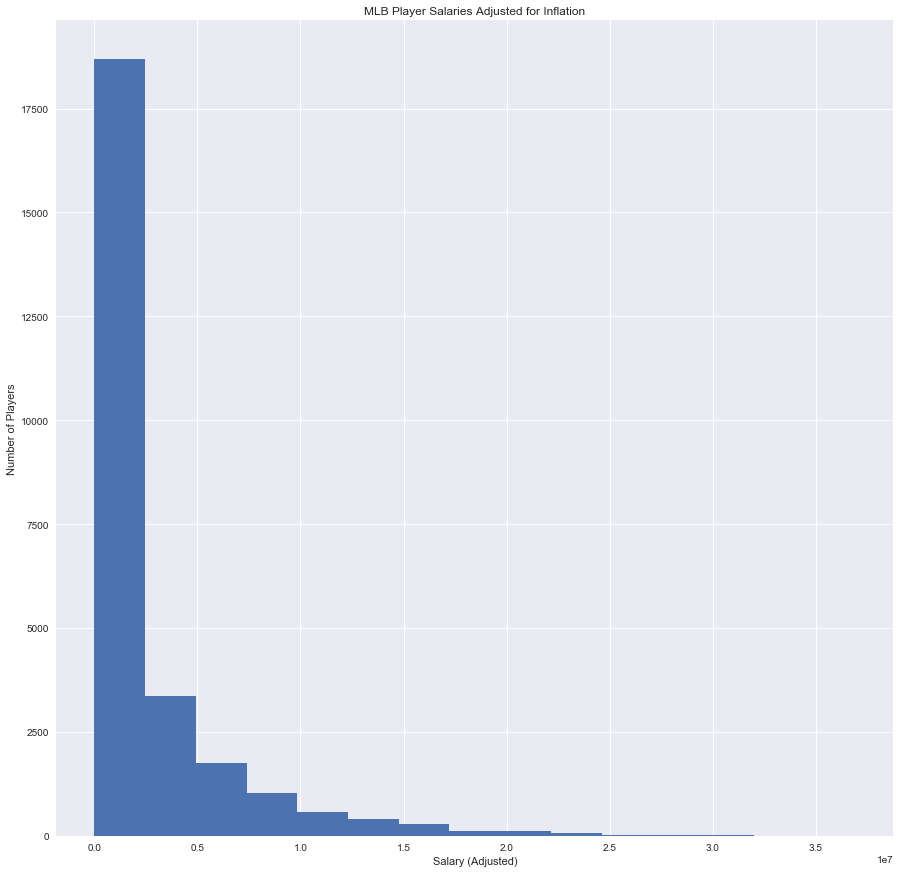

In [3]:
plt.figure(figsize=(15, 15))
plt.hist(salary['salary_adj'], bins=15)
plt.title('MLB Player Salaries Adjusted for Inflation')
plt.xlabel('Salary (Adjusted)')
plt.ylabel('Number of Players')
plt.show()

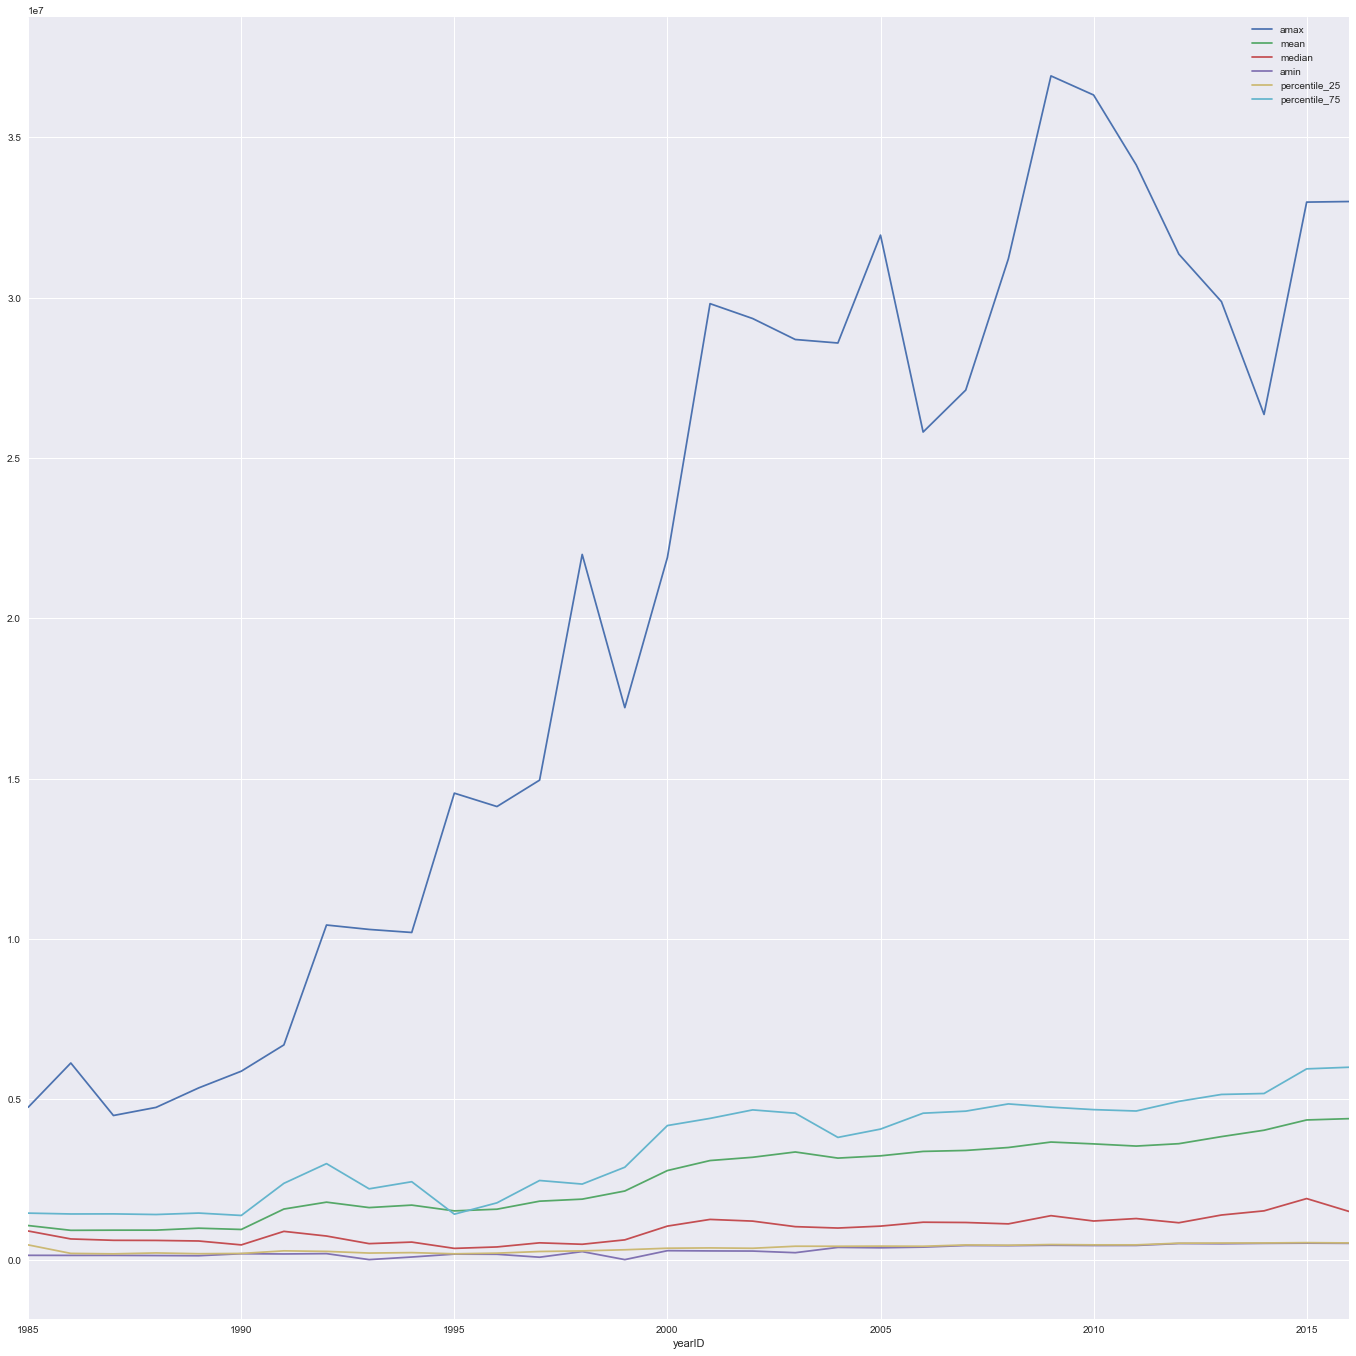

In [10]:
salary_by_year = salary.groupby(['yearID'])['salary_adj'].agg([np.max, np.mean, np.median, np.min, percentile(25), percentile(75)])
salary_by_year.plot(figsize=(19, 19))
plt.tight_layout()

### Question 1:
Baseball salaries seem to be top heavy. 

In [4]:
salary_by_player_year = salary.groupby(['yearID'])
top_ten_by_year = salary_by_player_year.apply(lambda x: x.nlargest(10, 'salary'))

sorted_salary = salary.sort_values('salary', ascending=False)
sorted_salary.groupby('yearID').apply(lambda x: x['salary'].iloc[0] - x['salary'].median())
top_ten_by_year.loc[2013]

,yearID,teamID,lgID,playerID,salary,cpi_u,salary_adj
23616,2013,NYA,AL,rodrial01,29000000,232.96,29877629.78
23698,2013,PHI,NL,leecl02,25000000,232.96,25756577.39
23621,2013,NYA,AL,wellsve01,24642857,232.96,25388626.14
23617,2013,NYA,AL,sabatcc01,24285714,232.96,25020674.89
23620,2013,NYA,AL,teixema01,23125000,232.96,23824834.09
23393,2013,DET,AL,fieldpr01,23000000,232.96,23696051.20
23580,2013,MIN,AL,mauerjo01,23000000,232.96,23696051.20
23803,2013,SFN,NL,linceti01,22250000,232.96,22923353.88
23496,2013,LAN,NL,gonzaad01,21857143,232.96,22518607.81
23388,2013,DET,AL,cabremi01,21000000,232.96,21635525.01


Why do some baseball players have a salary of 0??

In [ ]:
salary[salary['yearID'] == 2016]['salary'].hist()

In [5]:
plot_salary_sum = salary_by_year.sum().plot(figsize=(12,6))
plot_salary_sum.set(xlabel='Year', ylabel="Sum of Salaries")
plt.tight_layout()

NameError: name 'salary_by_year' is not defined

### Salary By Teams

In [7]:
salary.pivot_table('salary', index='yearID', columns='teamID')

teamID,ANA,ARI,ATL,BAL,BOS,CAL,CHA,CHC,CHN,CHW,...,SFG,SFN,SLN,STL,TBA,TBR,TEX,TOR,WAS,WSN
yearID,,,,,,,,,,,,,,,,,,,,,
1985,nan,nan,673045.45,525486.91,435902.40,515281.93,468865.62,nan,577405.32,nan,...,nan,411085.70,472683.32,nan,nan,nan,383825.00,440627.50,nan,nan
1986,nan,nan,589751.24,448319.24,496628.93,497491.66,336090.94,nan,555102.10,nan,...,nan,319535.71,365741.11,nan,nan,nan,259350.73,467075.81,nan,nan
1987,nan,nan,517017.50,463342.43,676277.80,475685.15,443410.12,nan,550307.65,nan,...,nan,316956.52,379290.32,nan,nan,nan,220000.00,455630.48,nan,nan
1988,nan,nan,438902.55,501187.96,579003.83,426692.43,266250.00,nan,524767.92,nan,...,nan,495200.00,477037.04,nan,nan,nan,242824.14,470816.35,nan,nan
1989,nan,nan,370411.13,318275.65,672374.92,580685.88,290616.40,nan,444500.00,nan,...,nan,534386.93,574244.04,nan,nan,nan,396459.37,580773.79,nan,nan
1990,nan,nan,454859.41,261623.89,642447.91,620571.43,306177.42,nan,439483.87,nan,...,nan,568686.26,586380.97,nan,nan,nan,402010.05,657660.52,nan,nan
1991,nan,nan,736140.00,565129.03,1172250.00,1066451.65,604273.82,nan,927026.68,nan,...,nan,1191064.08,753793.14,nan,nan,nan,867833.33,796096.68,nan,nan
1992,nan,nan,1116946.23,720626.27,1406793.03,1158311.13,1005361.10,nan,1065345.93,nan,...,nan,1326526.72,951166.76,nan,nan,nan,971876.35,1244129.61,nan,nan
1993,nan,nan,1261861.12,909265.62,1197438.16,893385.44,1280521.48,nan,1230833.31,nan,...,nan,1130645.16,778911.13,nan,nan,nan,957288.39,1432702.00,nan,nan


In [ ]:
# teams.merge(salary, on=['teamID', 'yearID'])
team_salary = teams.merge(salary.groupby(['teamID', 'yearID']).sum().reset_index(), on=['teamID', 'yearID'])
team_salary_by_year = team_salary.groupby(['yearID', 'teamID', 'W'])['salary'].sum().reset_index()
team_salary_by_year
#team_salary_by_year['rank'] = team_salary_by_year.groupby('yearID').rank()
team_salary_by_year['rank'] = team_salary_by_year.groupby('yearID')['salary'].rank()
#team_salary_by_year.pivot_table('rank', index='yearID', columns='teamID').plot(figsize=(20, 20))
team_salary_by_year.plot(kind='scatter', x='rank', y='W', figsize=(20, 20))
team_salary_by_year.head(5)

In [ ]:
cpiu_with_salary = team_salary.merge(cpi_u_values, on="yearID")
cpiu_with_salary = cpiu_with_salary[['yearID', 'teamID', 'W', 'salary', 'cpi_u']]
cpiu_with_salary['salary_adj'] = cpiu_with_salary.apply(lambda x: (x['salary'] * 240.007)/x['cpi_u'], axis=1)
cpiu_with_salary.plot(kind='scatter', x='salary_adj', y='W', figsize=(20, 20))

In [ ]:
#pd.options.display.float_format = '{:.2f}'.format
round(pd.read_csv('cpi_u_values.csv', float_precision='high').iloc[31]['Annual'], 3)

In [ ]:
salary_with_cpi